#  Esfera de Bloch y evolución temporal

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

En la ultima clase practica, vimos que la evolucion temporal que genera el siguiente hamiltoniano: 
$$ H_{\mathrm{tot}} = H_0 + H_I=\frac{\hbar \omega_0}{2} \sigma_z - \vec{d} \cdot  \vec{E} $$

con $\vec{E(t)} = E_0 \hat{\epsilon}\cos{(\omega_L t)}$ podía interpretarse como rotaciones en la esfera de Bloch. En este Notebook veremos algunas herramientas para visualizar eso.

Empecemos por describir lo que es la esfera de Bloch. Cualquier estado $\ket{\psi}$ puede parametrizarse con las variables $(\theta, \phi)$ de la siguiente forma: 

$$\ket{\psi} = \cos(\theta/2)\ket{e} + e^{i\phi}\sin(\theta/2)\ket{g}$$

y por lo tanto todos los posibles estados $\ket{\psi}$ de un sistema de dos niveles se pueden representar sobre la superficie de una esfera. Más concretamente, a cada estado la corresponde un punto sobre la esfera con las siguientes coordenadas: $\vec{a} = (\sin\theta\cos\phi, \sin\theta\sin\phi, \cos\theta)$. Al vector $\vec{a}$ se le llama vector de Bloch del estado $\ket{\psi}$. 

Hay un sentido físico inmediato de este vector: pueden comprobar que la compoente i-ésima del vector es igual al valor medio de la matriz de Pauli i-ésima. Es decir 
$$\begin{matrix}
\left \langle \sigma_x \right \rangle = \sin\theta\cos\phi\\ 
\left \langle \sigma_y \right \rangle = \sin\theta\sin\phi\\ 
\left \langle \sigma_z \right \rangle = \cos\theta
\end{matrix} $$

Veamos un ejemplo trivial. Si $\ket{\psi} = \ket{g}$ entonces $\theta = 0$ y $\vec{a} = (0, 0, 1)$. Por lo tanto $\left \langle \sigma_z \right \rangle = 1$ y $\left \langle \sigma_x \right \rangle = \left \langle \sigma_x \right \rangle = 0$. 


Para visualizarlo, es muy útil usar un toolbox de Python llamada "QuTip" (Quantum Toolbox in python). Qutip ofrece muchisimas clases y funciones para representar, visualizar y calcular dinamica de sistemas cuanticos. Aca vamos a usar principalmente la representacion y visualizacion en la esfera de Bloch. 

Empecemos con importar qutip y algunas otras cosas basicas: 

In [8]:
import qutip as qu
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import imageio
%matplotlib notebook

Ahora, vamos a definir un par de cosas basicas. En primer lugar, los estados $\ket{g}$ y $\ket{e}$.  En Qutip estos se pueden definir con la funcion "basis(dimension, n)". En nuestro caso la dimension es 2 y n=0 para el estado $\ket{e}$ y  n=1 para el estado $\ket{g}$ (esto viene del orden de la base que sale de usar $\sigma_z$ en el hamiltoniano). Tambien vamos a definir a las matrices de Pauli. 

Despues, una funcion para crear la visualizacion de la esfera de Bloch, y una que dado un estado, devuelve su vector de Bloch. 

In [9]:
e = qu.basis(2, 0)
g = qu.basis(2, 1)
sigmax, sigmay, sigmaz = qu.sigmax(), qu.sigmay(), qu.sigmaz()

def create_bloch_sphere(fig = None, axes = None):

    bloch = qu.Bloch(fig, axes)

    bloch.zlabel= ['$\\left|e\\right>$', '$\\left|g\\right>$']
    bloch.vector_color = 'k'
    return bloch

def bloch_vector(state):
    vec = np.array([qu.expect(sigmax, state), qu.expect(sigmay, state), qu.expect(sigmaz, state)])
    return vec

Ahora si, veamos un ejemplo sencillo. Definamos el estado $\ket{\psi} = \frac{\ket{g}+\ket{e}}{\sqrt{2}}$ y representemoslo en la esfera. 

<IPython.core.display.Javascript object>


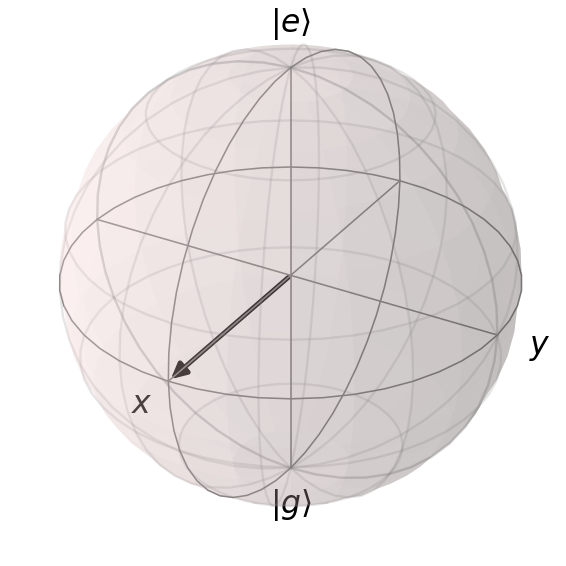

In [21]:
bloch = create_bloch_sphere()
state = (e+g)/np.sqrt(2)
bloch.add_states(state)
bloch.show()

Ahora igual con estados $\ket{\psi} = \frac{1}{\sqrt{2}}(\ket{g}+e^{i\phi}\ket{e})$ para distintos valores de $\phi$. 

<IPython.core.display.Javascript object>


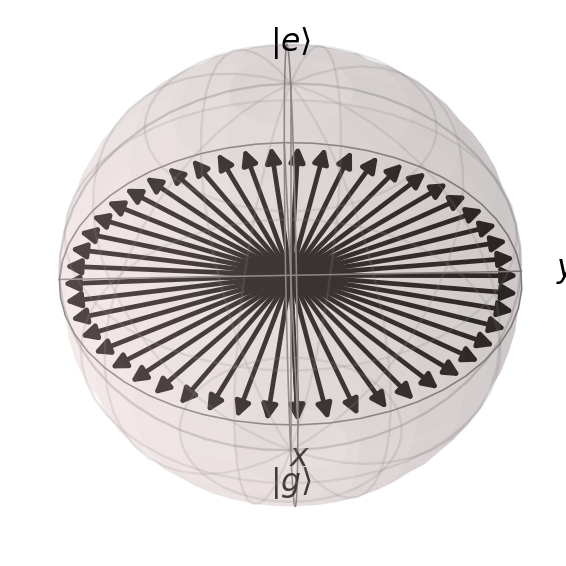

In [23]:
bloch = create_bloch_sphere()
phis = np.linspace(0, 2*np.pi, 50)
states = [(g + np.exp(1j*phi)*e)/np.sqrt(2) for phi in phis]
bloch.add_states(states)
bloch.show()

Definamos ahora el operador de rotación: $ \mathcal{D}(\phi, \hat{n}) = \exp\left [-i\frac{\phi}{2}(\vec{\sigma}\cdot\hat{n})\right ]$ y veamos que hace lo esperado. 

<IPython.core.display.Javascript object>


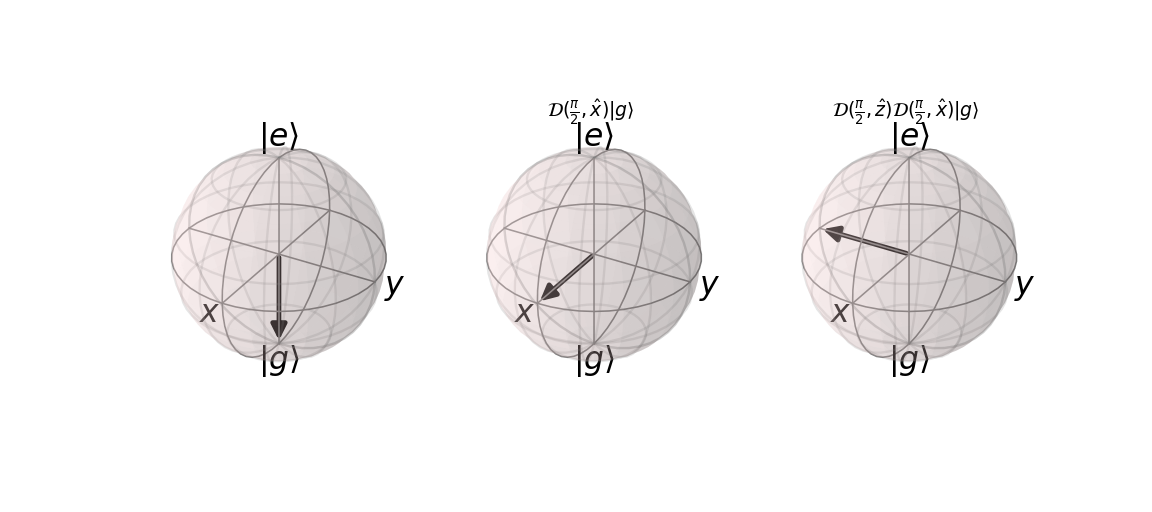

In [43]:
def D_op(phi, n):
    Id = qu.qeye(2)
    n_sig = n[0]*sigmax + n[1]*sigmay + n[2]*sigmaz
    return Id * np.cos(phi/2) + 1j * n_sig * np.sin(phi/2)

state1 = g
state2 = D_op(np.pi/2, (1, 0, 0)) * state
state3 = D_op(np.pi/2, (0, 0, 1)) * state2

fig = plt.figure(figsize = (9, 4))
N = 3
axs = [fig.add_subplot(1, 3, i+1, projection = '3d') for i in range(N)]   
blochs = [create_bloch_sphere(fig = fig, axes = axs[i]) for i in range(N)]
states = [state1, state2, state3]
for i in range(N):
    blochs[i].add_vectors(bloch_vector(states[i]))
    blochs[i].render(fig = fig, axes = axs[i])

axs[1].set_title(r'$\mathcal{D}(\frac{\pi}{2}, \hat{x})\left|{g}\right\rangle$');
axs[2].set_title(r'$\mathcal{D}(\frac{\pi}{2}, \hat{z})\mathcal{D}(\frac{\pi}{2}, \hat{x})\left|{g}\right\rangle$');


El otro dia en clase vimos algunas animaciones de evoluciones sobre la esfera. Aca les dejo una funcion que dada una lista de estados, crea un gif con esa evolucion. 

In [6]:
def animate_bloch(states, duration=0.1, save_all=False, output_file = 'bloch_anim.gif'):

    b = create_bloch_sphere()
    b.view = [-40,30]
    images=[]
    try:
        length = len(states)
    except:
        length = 1
        states = [states]
    ## normalize colors to the length of data ##
    nrm = mpl.colors.Normalize(0,length)
    colors = cm.prism(nrm(range(length))) # options: cool, summer, winter, autumn etc.

    ## customize sphere properties ##

    b.point_color = list(colors) # options: 'r', 'g', 'b' etc.
    b.point_marker = ['o']
    b.point_size = [30]
    sx, sy, sz = np.array([bloch_vector(s) for s in states]).transpose()

    for i in range(length):
        b.clear()
        b.add_states(states[i])
        #b.add_states(states[:(i+1)],'point')
        b.add_points([sx[:(i+1)], sy[:(i+1)], sz[:(i+1)]], meth = 'l')
        if save_all:
            b.save(dirc='tmp') #saving images to tmp directory
            filename="tmp/bloch_%01d.png" % i
        else:
            filename='temp_file.png'

            b.save(filename)
        images.append(imageio.imread(filename))
    imageio.mimsave(output_file, images, duration=duration)

Veamos un ejemplo:

In [47]:
initial_state = (g+e)/np.sqrt(2)
states = []
for phi in np.linspace(0, 2*np.pi):
    states.append(D_op(phi, [0, 0, 1]) * initial_state)
#animate_bloch(states, duration=0.1, save_all=False, output_file = 'bloch_anim_1.gif')

<img src='bloch_anim_1.gif' width="350" align="center">

Vimos en la practica (y se pide demostrar en los ejericios de la guía) que el hamiltoniano $ H_{\mathrm{tot}} = H_0 + H_I=\frac{\hbar \omega_0}{2} \sigma_z - \vec{d} \cdot  \vec{E} $ genera una evolución temporal que se compone de dos rotaciones: la primera es en la dirección $\hat{n} = (\frac{\Omega_0}{\Omega}, 0, -\frac{\delta}{\Omega})$ y de ángulo $ \phi = -\Omega t$ y la segunda es en la dirección $\hat{z}$ y de ángulo $ \phi = \delta \,t$. Recordemos que $\Omega = \sqrt{\Omega_0^2+\delta^2}$. La 2da de estas rotaciones es la que viene de haber hecho un cambio de variables, al que llamamos "marco rotante con el láser". Podemos entonces definir una función que genere esta evolución temporal. 

In [48]:
def pulse_evolution(t, rabi_freq, delta, initial_state = g, t0 = 0):
    r = np.sqrt(rabi_freq**2+delta**2)
    n = [rabi_freq/r, 0, -delta/r]
    z = [0, 0, 1]
    t = t - t0
    return D_op(delta * t, z) * D_op(-r * t, n) * initial_state

Veamos por ejemplo, lo que sucede si $\delta=0$ y hacemos un pulso de $\frac{\pi}{2}$. Para mejor visualización, agregamos un código de colores que indique la evolución entre $t_0$ y $t_f$. 

<IPython.core.display.Javascript object>


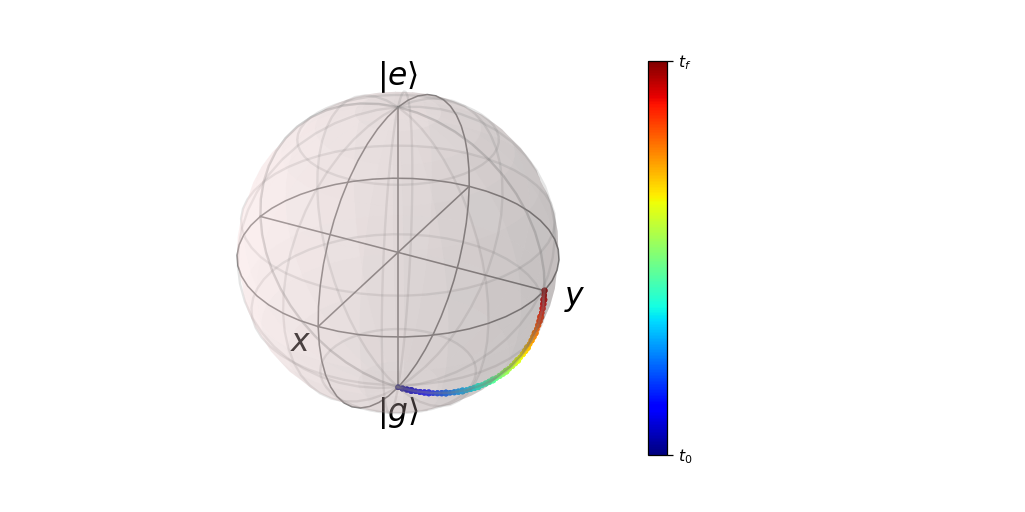

In [99]:
fig = plt.figure(figsize = (8, 4))
ax1 = fig.add_subplot(121, projection = '3d')
ax2 = fig.add_subplot(122)

rabi_freq = 1
delta = 0
tau_final = 0.5 * np.pi/rabi_freq
t = np.linspace(0, tau_final)
states = [pulse_evolution(ti, rabi_freq, delta, initial_state=g) for ti in t]
bloch = create_bloch_sphere(fig = fig, axes = ax1)

length = len(states)
nrm = mpl.colors.Normalize(0,length)
colors = cm.jet(nrm(range(length))) # options: cool, summer, winter, autumn etc.
bloch.point_color = list(colors) # options: 'r', 'g', 'b' etc.

#bloch.point_color = 'k'
bloch.point_marker = '.'
bloch.add_states(states, kind = 'point')
bloch.render(fig, ax1)
ax2.set_aspect(20)
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cm.jet, norm=nrm, orientation='vertical', ticks = [0, 50]);
cbar.set_ticklabels([r'$t_0$',r'$t_f$'])
plt.subplots_adjust(wspace = -0.5)

Veamos la evolución temporal para un caso en que $\delta \neq  0$. En particular pondremos $\delta = 2\Omega_0$. Ademas, podemos hacer un gráfico de la evolución temporal de la probabilidad de encontrar al sistema en el estado excitado. Esto puede calcularse como $P_e(t) = \left |\left\langle e| \psi \right\rangle
  \right |^2 $ 

<IPython.core.display.Javascript object>


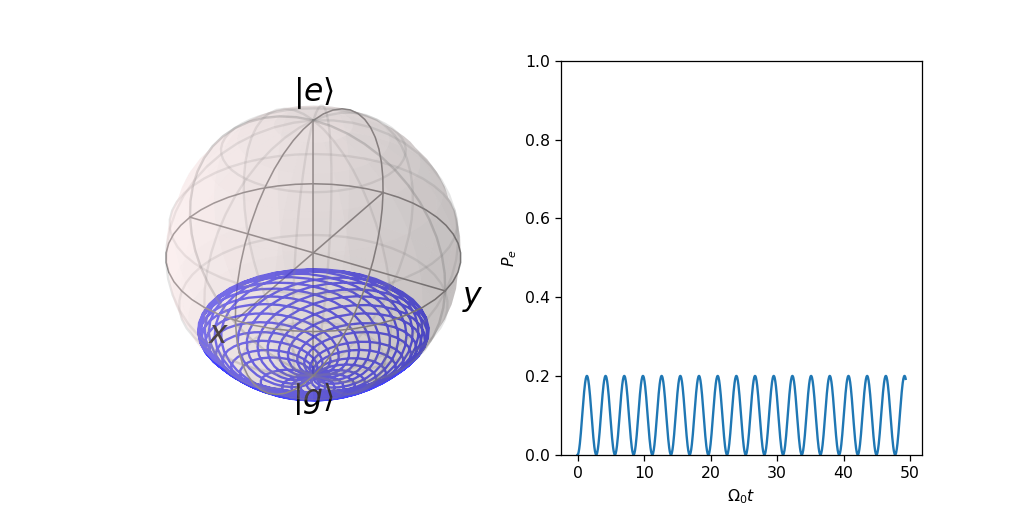

In [123]:
rabi_freq = 1
delta = 2
tau_final = 5*np.pi * np.pi/rabi_freq 
t = np.linspace(0, tau_final, 1000)
states = [pulse_evolution(ti, rabi_freq, delta) for ti in t]
sx, sy, sz = np.array([bloch_vector(s) for s in states]).transpose()

fig = plt.figure(figsize = (8, 4))
ax1 = fig.add_subplot(121, projection = '3d')
ax2 = fig.add_subplot(122)

bloch = create_bloch_sphere(fig = fig, axes = ax1)
bloch.add_points([sx,sy,sz], meth = 'l')
bloch.render(fig = fig, axes = ax1)

p = [np.abs( s.overlap(e) )**2 for s in states]
ax2.plot(t*rabi_freq, p)
ax2.set_ylim(0, 1); ax2.set_xlabel('$\Omega_0t$');ax2.set_ylabel(r'$P_e$');
#animate_bloch(states, duration=0.1, save_all=False, output_file='bloch_anim_2.gif')

<img src='bloch_anim_2.gif' width="350" align="center">

Tambien podemos ver cómo evoluciona el sistema en una secuencia tipo Ramsey, en la que partiendo del fundamental, se aplican 2 pulsos $\frac{\pi}{2}$ separados por un intervalo de duración $T$ en la que no se aplican nigun campo externo. En el intervalo de espera, la probabilidad $P_e$ se mantiene constante. Sin embargo, el sistema evoluciona rotando alrededor de $\hat{z}$ con la desintonía! Esa evolución es la que genera oscilaciones al final de la secuencia. 

<IPython.core.display.Javascript object>


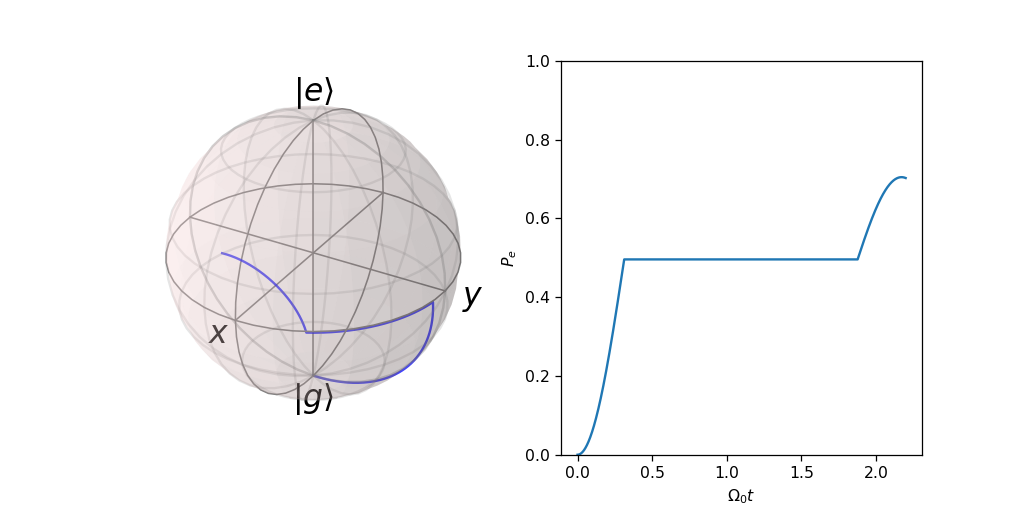

In [124]:
rabi_freq = 5
delta = 0.3
tau = 0.5 * np.pi/rabi_freq 
T = tau * 5
time_steps = 200
t1 = np.linspace(0, tau, time_steps, endpoint = False)
t2 = np.linspace(tau, tau + T, time_steps, endpoint = False)
t3 = np.linspace(tau + T, 2* tau + T, time_steps)

states1 = [pulse_evolution(ti, rabi_freq, delta, initial_state = g) for ti in t1]
states2 = [pulse_evolution(ti, 0, delta, initial_state = states1[-1], t0 = t1[-1]) for ti in t2]
states3 = [pulse_evolution(ti, rabi_freq, delta, initial_state = states2[-1], t0 = t2[-1]) for ti in t3]
states = states1+states2+states3
sx, sy, sz = np.array([bloch_vector(s) for s in states]).transpose()


fig = plt.figure(figsize = (8, 4))
ax1 = fig.add_subplot(121, projection = '3d')
ax2 = fig.add_subplot(122)

bloch = create_bloch_sphere(fig = fig, axes = ax1)
bloch.add_points([sx,sy,sz], meth = 'l')
bloch.render(fig = fig, axes = ax1)

t = np.concatenate((t1,t2, t3))
p = [np.abs( s.overlap(e) )**2 for s in states]
ax2.plot(t, p)
ax2.set_ylim(0, 1);ax2.set_xlabel('$\Omega_0t$');ax2.set_ylabel('$P_e$');

Veamos entonces como se comporta $P_e$ al final de la secuencia para distintos valores de $\delta$. 

<IPython.core.display.Javascript object>


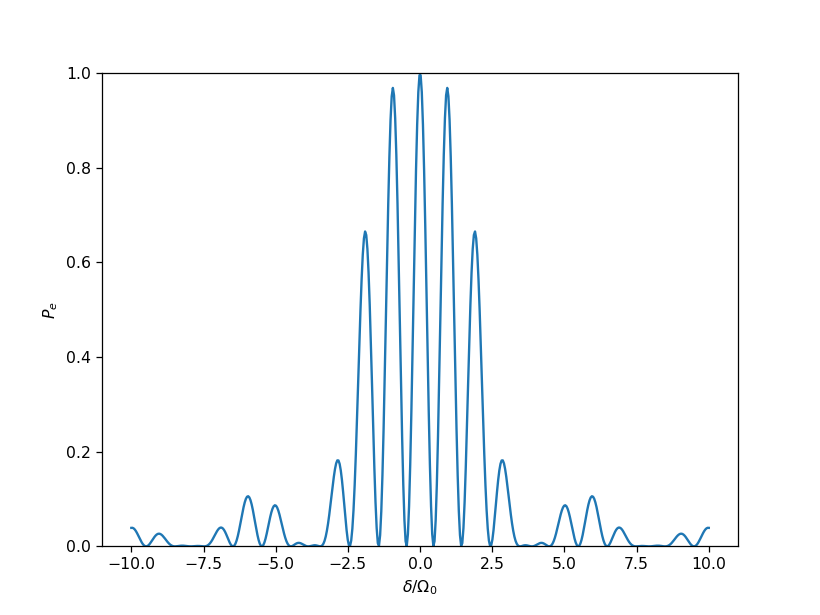

In [129]:
def Pe_ramsey(rabi_freq, delta, T):

    tau = 0.5 * np.pi/rabi_freq 

    state = pulse_evolution(tau, rabi_freq, delta, initial_state = g)
    state = pulse_evolution(T*tau, 1e-12, delta, initial_state = state)
    state = pulse_evolution(tau, rabi_freq, delta, initial_state = state)

    return np.abs(state.overlap(e) )**2

rabi_freq = 2
deltas = np.linspace(-20, 20, 500)

T = 1
Pe = [Pe_ramsey(rabi_freq, delta, T) for delta in deltas]
plt.figure()
plt.plot(deltas/rabi_freq, Pe)
plt.ylim(0, 1);plt.xlabel('$\delta / \Omega_0$');plt.ylabel('$P_e$');

Un comentario final sobre el método de Ramsey. Puede resultar anti-intuitivo el hecho de que durante el tiempo de espera, en el cuál no hay un campo externo aplicado, el sistema evoluciona de todas formas, y que esa evolución venga dada por $\delta$ que depende del láser. Veamos una forma de entender esto. 

En clase dijimos que es posible escribir al operador $\vec{d}$ de la forma $\vec{d} = \bra{g}\vec{d}\ket{e} (\sigma_++\sigma_-) = \bra{g}\vec{d}\ket{e}\sigma_x$, utilizando el hecho de que sus elementos diagonales son cero, y asumiendo que $\bra{g}\vec{d}\ket{e} = \bra{e}\vec{d}\ket{g}$. Bien, ahora eso no es tan obvio, porque en principio $ \bra{g}\vec{d}\ket{e} =  \bra{e}\vec{d}\ket{g}^*$ (dado que $\vec{d}$ es un observable y por lo tanto un operador hermítico) pero no son necesariamente iguales. 

Sin embargo, puede demostrarse sin mucha dificultad que puede elegirse una fase $\varphi$ en el láser (en cuyo caso $\vec{E(t)} = E_0 \hat{\epsilon}\cos{(\omega_L t+\varphi)}$) de tal forma de que se cancele con la fase compleja de $\bra{g}\vec{d}\ket{e}$ y que por lo tanto el operador $\vec{d}$ resulte proporcional a $\sigma_x$ como hicimos en clase. Tambien esto puede interpretarse como que etamos eligiendo las direcciones $x$ e $y$ para que inicialmente $\vec{d}$ resulte proporcional a $\sigma_x$. En fin, todo esto puede hacerse "inocentemente" porque en muchos casos la fase incial del láser respecto al sistema atómico no tiene importancia. Sin embargo, en el método de Ramsey, esa fase es justamente la clave del problema, y es lo que genera la señal de interfencia: cuando aplicamos el segundo pulso, la relación de fase entre el láser y el sistema atómico es fundamental. 